In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.table import Table
from astropy.io import fits

import galsim
import galsim.des
import euclidlike

# Define Euclidlike-PSF

In [4]:
image_pos = galsim.PositionD(0, 0)
euclidlike_bp = euclidlike.getBandpasses()['VIS']
euclidlike_bp.red_limit = 910
euclidlike_bp.blue_limit = 540
wl_array, psfobjs = euclidlike.get_euclid_wavelength_psf()
wave = wl_array[9]  # random wavelength from oversampled images
euclidlike_psf = euclidlike.getPSF(0, 'VIS', ccd_pos=image_pos)
flat_sed = galsim.SED(galsim.LookupTable([100, 2600], [1, 1], interpolant='linear'),
                              wave_type='nm', flux_type='fphotons')
pixel_response = galsim.Pixel(euclidlike.pixel_scale)
euclidlike_psf = galsim.Convolve(euclidlike_psf, pixel_response*flat_sed)
euclidlike_psf = euclidlike_psf.withFlux(1.0, euclidlike_bp)

# Define ERO-PSF

In [5]:
ero_path = "/hildafs/projects/phy200017p/share/euclid_sim/ERO/ERO-Perseus-VIS-CAT"
psf_path = os.path.join(ero_path, "Euclid-VIS-ERO-Perseus-Flattened.DR3.psfex.psf")
ero_psfex = galsim.des.DES_PSFEx(psf_path, wcs=galsim.PixelScale(0.1))
ero_psf = ero_psfex.getPSF(image_pos)
scale = ero_psfex.getSampleScale() * euclidlike.pixel_scale

# Plot the PSF and residual

In [6]:
euclidlike_psf_image = euclidlike_psf.drawImage(bandpass=euclidlike_bp, nx=128, ny=128, scale=scale, method='no_pixel')
ero_psf_image = ero_psf.drawImage(bandpass=euclidlike_bp, nx=128, ny=128, scale=scale, method='no_pixel')

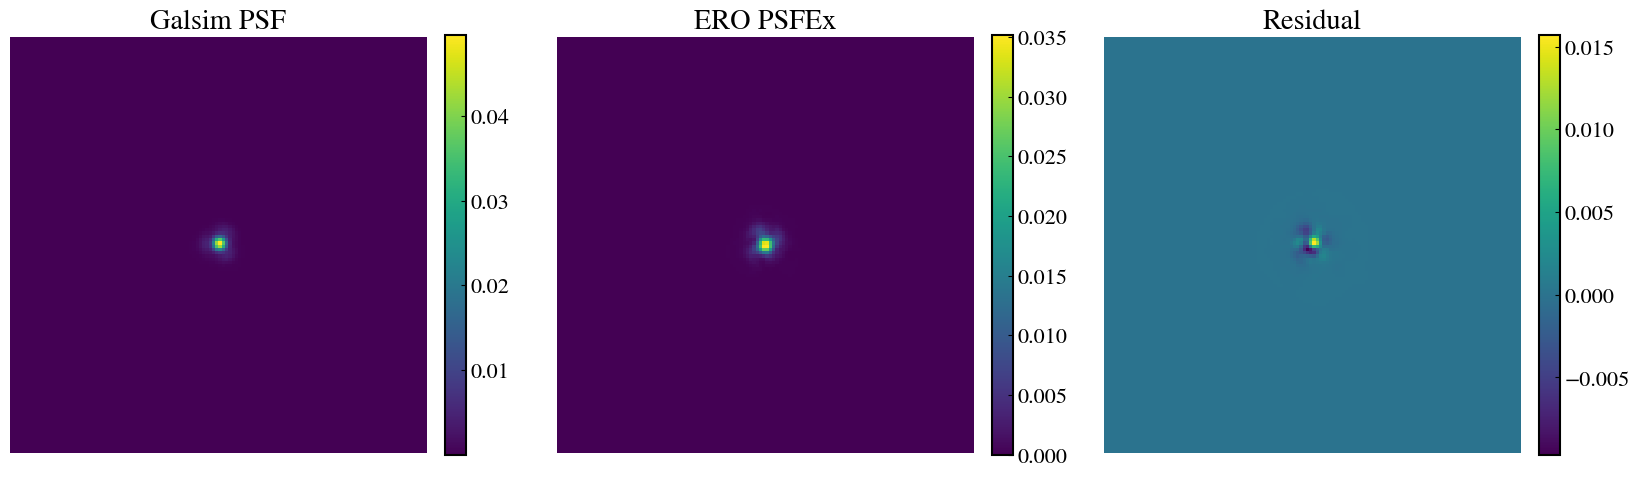

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))
im0 = axs[0].imshow(euclidlike_psf_image.array, origin='lower', aspect='equal')
axs[0].set_title('Galsim PSF')
axs[0].axis('off');
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(ero_psf_image.array, origin='lower', aspect='equal')
axs[1].set_title('ERO PSFEx')
axs[1].axis('off');
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(euclidlike_psf_image.array - ero_psf_image.array, origin='lower', aspect='equal')
axs[2].set_title('Residual')
axs[2].axis('off');
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

Text(0.5, 1.0, 'mean x')

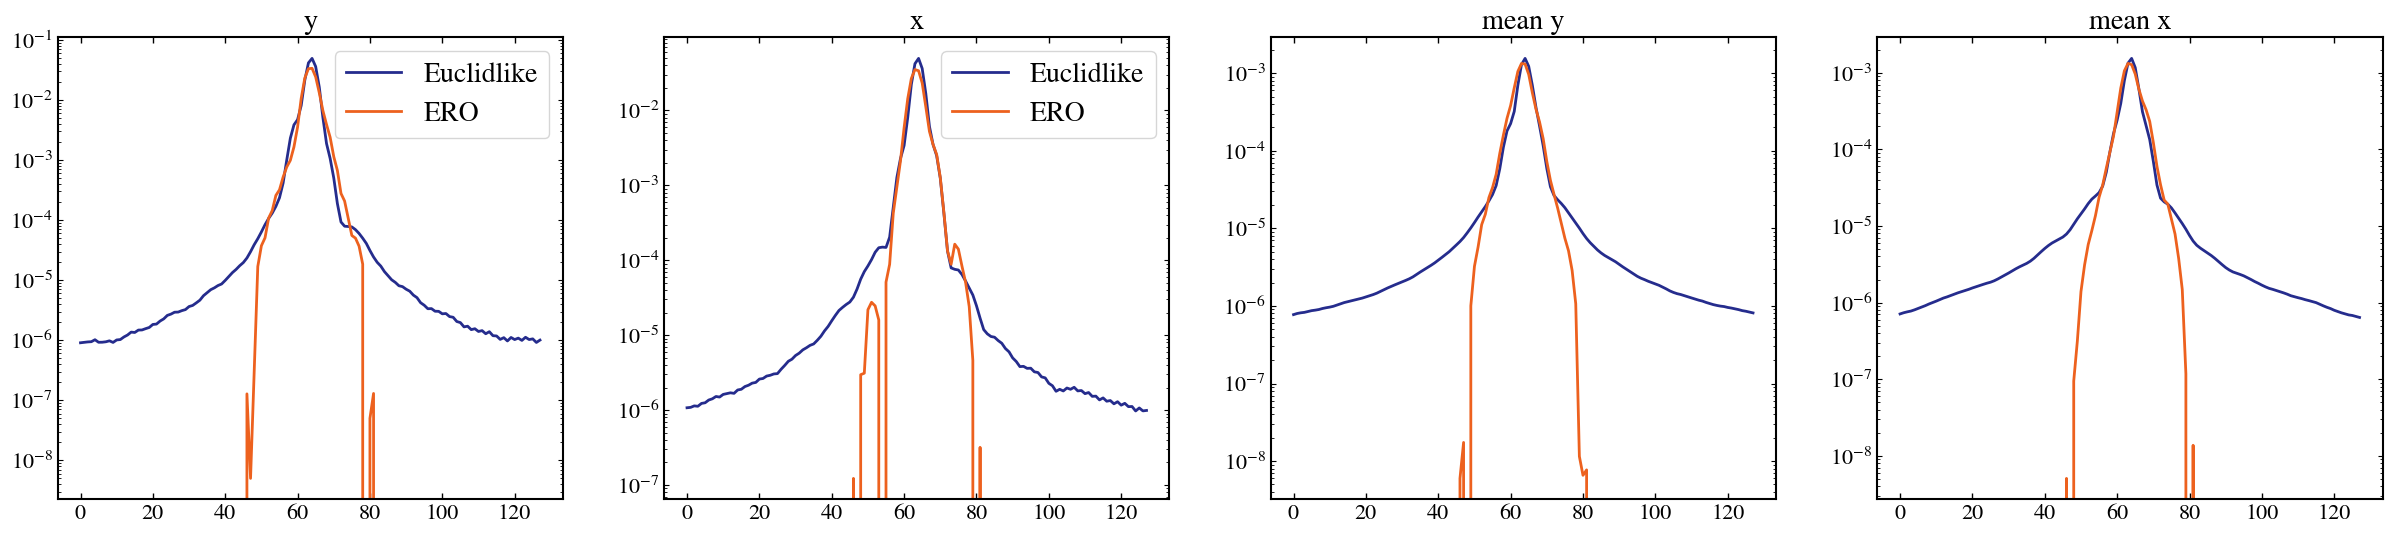

In [24]:
cx, cy = euclidlike_psf_image.array.shape
cx = int(cx / 2)
cy = int(cy / 2)

fig, axs = plt.subplots(ncols=4, figsize=(30, 6))

axs[0].plot(euclidlike_psf_image.array[cy, :], label='Euclidlike')
axs[0].plot(ero_psf_image.array[cy, :], label='ERO')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('y')

axs[1].plot(euclidlike_psf_image.array[:, cx], label='Euclidlike')
axs[1].plot(ero_psf_image.array[:, cx], label='ERO')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('x')

axs[2].plot(np.mean(euclidlike_psf_image.array, axis=0))
axs[2].plot(np.mean(ero_psf_image.array, axis=0))
axs[2].set_yscale('log')
axs[2].set_title('mean y')

axs[3].plot(np.mean(euclidlike_psf_image.array, axis=1))
axs[3].plot(np.mean(ero_psf_image.array, axis=1))
axs[3].set_yscale('log')
axs[3].set_title('mean x')

# Compare 2nd moment based size and shape

In [12]:
euclidlike_moments = galsim.hsm.FindAdaptiveMom(euclidlike_psf_image, use_sky_coords=True)
ero_moments = galsim.hsm.FindAdaptiveMom(ero_psf_image, use_sky_coords=True)

In [24]:
ero_moments.observed_shape.shear

(-0.008069364997193677+0.02316293334719364j)

In [15]:
size_frac = np.abs((euclidlike_moments.moments_sigma - ero_moments.moments_sigma) / euclidlike_moments.moments_sigma)
shape_frac

-0.22685568947289445